In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test_no_answer.csv')

In [3]:
df_train

,row_id,TEXT,LABEL
0,0,good to know if you can t find these elsewhere .,1
1,1,love it ! the grill plates come out and pop i...,1
2,2,i m convinced this was a poorly executed refur...,0
3,3,i would never have complained about that if it...,0
4,4,"the photo shows the same whole , large candie...",0
...,...,...,...
10995,10995,i didn t quite get it the first time .,1
10996,10996,i ve tried installing with and without the oem...,0
10997,10997,i was parked at a truck stop in the cincinnati...,0
10998,10998,i recently bought this case after seeing some ...,1


In [4]:
# there is no .isupper()
uppercase_count = 0
for index, row in df_train.iterrows():
    if row['TEXT'].isupper():
        uppercase_count += 1
uppercase_count

0

### Exploring: frequency distributions
https://realpython.com/python-nltk-sentiment-analysis/#using-nltks-pre-trained-sentiment-analyzer

In [5]:
import nltk
from pprint import pprint

In [6]:
df_train.loc[0]

row_id                                                   0
TEXT      good to know if you can t find these elsewhere .
LABEL                                                    1
Name: 0, dtype: object

In [7]:
text = df_train.loc[0]['TEXT']
pprint(nltk.word_tokenize(text), compact=True)

['good', 'to', 'know', 'if', 'you', 'can', 't', 'find', 'these', 'elsewhere',
 '.']


In [8]:
# tokenize all sentence
# there is no .isupper()
full_text = ''
for index, row in df_train.iterrows():
    full_text += row['TEXT']

In [9]:
# find most common words
words = nltk.word_tokenize(full_text)
fd = nltk.FreqDist(words)

In [10]:
fd.most_common(3)

[('the', 5925), (',', 4510), ('and', 3967)]

In [11]:
fd.tabulate(20)

 the    ,  and   it    a   to    i   .i   is  for   of this   in   my that  not with    t have   on 
5925 4510 3967 3621 3487 3364 2889 2858 2282 2019 1962 1944 1453 1388 1259 1171 1159 1140 1136 1111 


### Extracting Concordance and Collocations
恩...不會

In [12]:
text = nltk.Text(df_train['TEXT'])
text.concordance("more", lines=5)

no matches


In [13]:
text

<Text: good to know if you can t find these elsewhere . love it !  the grill plates come out and pop in the dishwasher ,  which is fantastic . i m convinced this was a poorly executed refurbished unit as small repairs could be seen in many pieces . i would never have complained about that if it would just keep working ,  for gosh sakes . the photo shows the same whole ,  large candies we ve always gotten . he finds it to be extremely boring and will play with the  more advanced  musical toys instead . rusho ,  i followed your mounting procedures and they work great !  !  !  . the air bubble will go down the side and the bottle will not break ....>

### Browse length on sentence
ref; [Text Classification using Neural Networks](https://www.kaggle.com/eliotbarr/text-classification-using-neural-networks)

In [14]:
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
%matplotlib inline

Using TensorFlow backend.


(array([5500.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5500.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

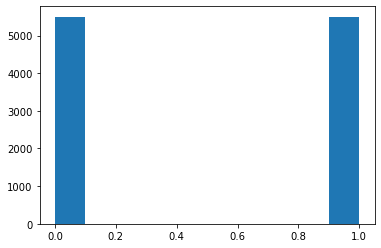

In [15]:
plt.hist(df_train['LABEL'])

#### Tokenize

The following cells uses Keras to preprocess text:

- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the 20000 most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length 1000)
- we convert the output classes as 1-hot encodings

In [16]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = df_train['TEXT'].astype(str)
texts_test = df_test['TEXT'].astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9872 unique tokens.


In [17]:
sequences[0]

[46, 6, 170, 37, 17, 33, 19, 195, 35, 856]

In [18]:
df_train['TEXT'].loc[0]

'good to know if you can t find these elsewhere .'

In [19]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 9872)

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [20]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [21]:
" ".join([index_to_word[i] for i in sequences[0]])

'good to know if you can t find these elsewhere'

#### Let's have a closer look at the tokenized sequences:

In [22]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 13.5
max length: 25


(array([  10.,  767.,  977., 1017., 1018., 1009.,  987.,  917.,  884.,
           0.,  837.,  762.,  728.,  708.,  277.,   78.,   18.,    4.,
           0.,    2.]),
 array([ 7. ,  7.9,  8.8,  9.7, 10.6, 11.5, 12.4, 13.3, 14.2, 15.1, 16. ,
        16.9, 17.8, 18.7, 19.6, 20.5, 21.4, 22.3, 23.2, 24.1, 25. ]),
 <BarContainer object of 20 artists>)

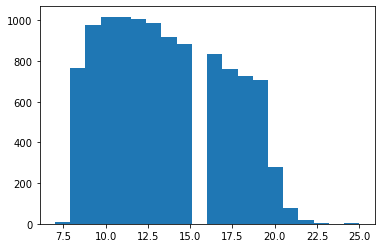

In [23]:
plt.hist(seq_lens, bins=20)

its looks very good, no need any adjust on length

### 資料前處理: 將't加回原詞
Google's word2vector contains: "cant" "can't"  
so wo does <font color="red">can t => can't</font>, put these into a single word.  
  
ps: word2vec 裡沒有 <font color="red">'and', 'a', 'to', 'of'</font> !

In [24]:
"'".join("can t".split())

"can't"

In [25]:
negative_words = ["can t","couldn t","wouldn t","shouldn t","ain t",
                  "didn t","don t","doesn t",
                  "wasn t","isn t","aren t","hasn t","haven t","won t"]

In [26]:
mapping = {}
for n in negative_words:
    mapping[n] = "'".join(n.split())
mapping

{'can t': "can't",
 'couldn t': "couldn't",
 'wouldn t': "wouldn't",
 'shouldn t': "shouldn't",
 'ain t': "ain't",
 'didn t': "didn't",
 'don t': "don't",
 'doesn t': "doesn't",
 'wasn t': "wasn't",
 'isn t': "isn't",
 'aren t': "aren't",
 'hasn t': "hasn't",
 'haven t': "haven't",
 'won t': "won't"}

In [27]:
arr = []
for index, row in df_train.iterrows():
    contains = False
    for _ in negative_words:
        contains = contains or (_ in row['TEXT'])
    if contains:
        arr.append(row['TEXT'])
len(arr)

1109

In [28]:
arr[100:110]

['as far as i m concerned that is a big omission . inside the unit ,  don t expect to cook large volumes .',
 'so while it wasn t leaking yet ,  i worried that it might in the future .',
 'i don t see any need for these ,  especially since they are deadly to humans and pets .',
 'how can you go wrong with beef jerky ?  you can t except this one wasn t that great .',
 'i couldn t push the buttons for volume or power at all .',
 'i don t like the ingredients ,  but that does not trouble some of the people in our household either .',
 'i didn t think about that when i purchased them .',
 'i couldn t even finish the whole box; i had to throw out most of it .',
 'just make sure you carefully clean out the cutting channel so cheese or other food doesn t accumulate in there .',
 'i love that it doesn t add any bulk to the phone and still protects my phone .']

In [29]:
# apply to dataframe
def cat_negative_words(sentence):
    for n in negative_words:
        sentence = sentence.replace(n, mapping[n])
    return sentence

df_train['TEXT'] = df_train['TEXT'].apply(lambda x: cat_negative_words(x) )
df_test['TEXT']  = df_test['TEXT'].apply(lambda x: cat_negative_words(x) )

In [30]:
df_train.head(3)

,row_id,TEXT,LABEL
0,0,good to know if you can't find these elsewhere .,1
1,1,love it ! the grill plates come out and pop i...,1
2,2,i m convinced this was a poorly executed refur...,0


去掉 <font color="red">'and', 'a', 'to', 'of'</font> 方便處理oov。(GloVe含有這些stop words但我就懶)

In [31]:
# apply to dataframe
import re
stops = ['and', 'a', 'to', 'of']
def rm_stop_words(sentence):
    for n in stops:
        sentence = re.sub(r"\s+"+n+"\s+", ' ', sentence)
    return sentence

df_train['TEXT'] = df_train['TEXT'].apply(lambda x: rm_stop_words(x) )
df_test['TEXT']  = df_test['TEXT'].apply(lambda x: rm_stop_words(x) )
df_train.head(3)

,row_id,TEXT,LABEL
0,0,good know if you can't find these elsewhere .,1
1,1,love it ! the grill plates come out pop in th...,1
2,2,i m convinced this was poorly executed refurbi...,0


In [33]:
# df_train.to_csv('data/train_cleaned.csv', index=False)
# df_test.to_csv('data/test_no_answer_cleaned.csv', index=False)